In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [8]:
data = pd.read_csv("car.csv")

In [9]:
# Definisi fungsi untuk menghitung Gini Index
def gini_index(groups, classes):
    # Hitung total sampel
    total_samples = sum([len(group) for group in groups])
    gini = 0.0
    for group in groups:
        size = len(group)
        if size == 0:  # Hindari pembagian nol
            continue
        score = 0.0
        # Proporsi setiap kelas
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # Hitung Gini untuk grup ini
        gini += (1.0 - score) * (size / total_samples)
    return gini

# Split dataset berdasarkan atribut dan nilai tertentu
def test_split(index, value, dataset):
    left, right = [], []
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# Cari split terbaik untuk dataset
def get_best_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    best_index, best_value, best_score, best_groups = None, None, float('inf'), None
    for index in range(len(dataset[0]) - 1):  # Iterasi setiap fitur
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < best_score:
                best_index, best_value, best_score, best_groups = index, row[index], gini, groups
    return {'index': best_index, 'value': best_value, 'groups': best_groups}

# Buat terminal node
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

# Membagi node atau membuat cabang
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # Cek jika ada node kosong
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # Cek jika mencapai kedalaman maksimum
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # Proses cabang kiri
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_best_split(left)
        split(node['left'], max_depth, min_size, depth + 1)
    # Proses cabang kanan
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_best_split(right)
        split(node['right'], max_depth, min_size, depth + 1)

# Bangun pohon keputusan
def build_tree(train, max_depth, min_size):
    root = get_best_split(train)
    split(root, max_depth, min_size, 1)
    return root

# Membuat prediksi dengan pohon
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Data preprocessing
dataset = data[['Age', 'AnnualSalary', 'Purchased']].values.tolist()

# Bangun pohon keputusan
tree = build_tree(dataset, max_depth=3, min_size=1)

# Evaluasi model
y_true = [row[-1] for row in dataset]
y_pred = [predict(tree, row) for row in dataset]
accuracy = np.mean(np.array(y_true) == np.array(y_pred)) * 100

print(f"Akurasi: {accuracy:.2f}%")


Akurasi: 90.10%


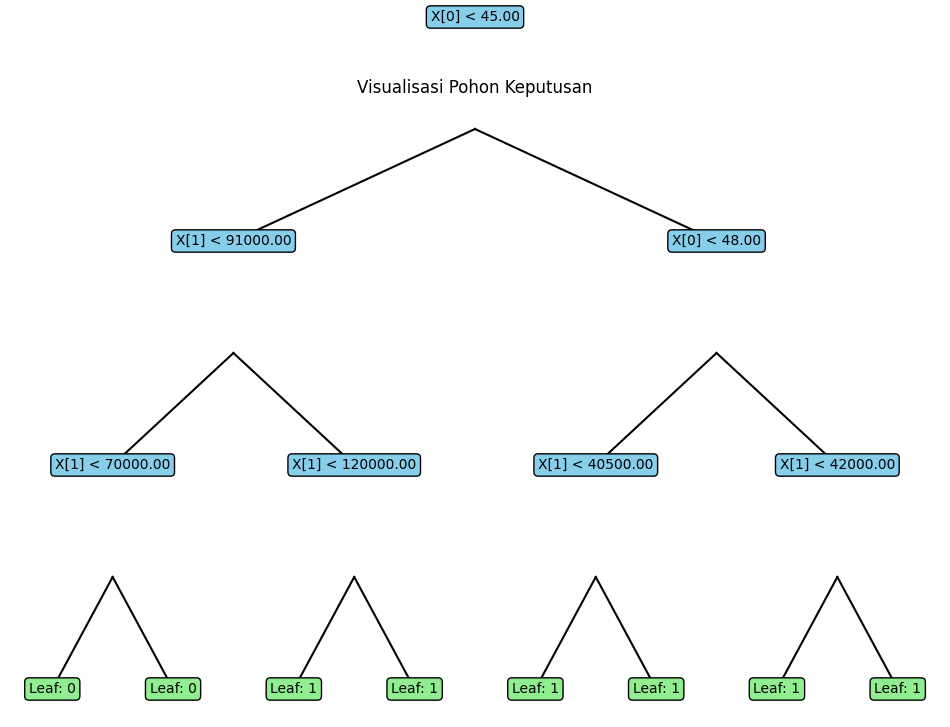

In [11]:
import matplotlib.pyplot as plt

# Fungsi untuk menggambar pohon keputusan secara manual
def plot_tree_matplotlib(node, x=0.5, y=1, layer=1, width=0.2):
    if isinstance(node, dict):
        # Menambahkan kotak untuk pembagian saat ini
        feature = f"X[{node['index']}] < {node['value']:.2f}"
        plt.text(x, y, feature, ha="center", va="center", fontsize=10, bbox=dict(facecolor="skyblue", edgecolor="black", boxstyle="round,pad=0.3"))

        # Menggambar garis untuk cabang kiri dan kanan
        if isinstance(node['left'], dict):
            plt.plot([x, x - width], [y - 0.2, y - 0.4], 'k-')
            plot_tree_matplotlib(node['left'], x - width, y - 0.4, layer + 1, width / 2)
        else:
            plt.plot([x, x - width], [y - 0.2, y - 0.4], 'k-')
            plt.text(x - width, y - 0.4, f"Leaf: {node['left']}", ha="center", va="center", fontsize=10, bbox=dict(facecolor="lightgreen", edgecolor="black", boxstyle="round,pad=0.3"))

        if isinstance(node['right'], dict):
            plt.plot([x, x + width], [y - 0.2, y - 0.4], 'k-')
            plot_tree_matplotlib(node['right'], x + width, y - 0.4, layer + 1, width / 2)
        else:
            plt.plot([x, x + width], [y - 0.2, y - 0.4], 'k-')
            plt.text(x + width, y - 0.4, f"Leaf: {node['right']}", ha="center", va="center", fontsize=10, bbox=dict(facecolor="lightgreen", edgecolor="black", boxstyle="round,pad=0.3"))

# Fungsi utama untuk menggambar pohon keputusan
def visualize_tree_matplotlib(tree):
    plt.figure(figsize=(12, 8))
    plot_tree_matplotlib(tree)
    plt.axis('off')
    plt.title("Visualisasi Pohon Keputusan")
    plt.show()

# Panggil visualisasi pohon
visualize_tree_matplotlib(tree)